In [4]:
import ml
reload(ml)
from ml import *
import rfpimp
reload(rfpimp)
from rfpimp import *
import timeit
import scipy
import operator
import numpy as np
import pandas as pd
import cPickle as pickle
from scipy import stats
# import seaborn as sns
from datetime import datetime
from sklearn.utils import resample
from collections import Counter, defaultdict
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
from pprint import pprint
from __future__ import division
# import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
plt.style.use('classic')
%matplotlib inline

__author__ = 'HK Dambanemuya'
__version__ = 'Python 2'

'''
    Analysis originaly performed in Python 2 (deprecated)
    Seaborn, Statsmodel, and * imports broken in Python 3
'''

## Methods

In [4]:
def cov(arr):
    return np.std(arr) / np.mean(arr) 

def fundingTime(arr):
    return (pd.to_datetime(arr.max()) - pd.to_datetime(arr.min())).days

def interEventTime(arr):
    return [(pd.to_datetime(t) - pd.to_datetime(s)).seconds for s, t in zip(sorted(arr), sorted(arr)[1:])]

def avgInterEventTime(arr):
    return np.mean(interEventTime(arr))

def covInterEventTime(arr):
    varr = interEventTime(arr)
    return np.std(varr) / np.mean(varr) 

def truncate_date(x):
    if x.date:
        try:
            return x.strftime('%Y%m')
        except:
            return None

## Data

In [5]:
investments = pd.read_csv("../Data/full.csv")
investments.sample(10)

,investorid,name,city,county,country,amount,campaign,state,visibility,created,selfcertification,passedquiz,id,username,percentageofequityoffered,investmentsought,premoneyvaluation,createdat,eiscompliant,seiscompliant,slug,approvedat,numberofentrepreneurs,categories
45684,436.000,Senthil Mani,Reading,Berkshire,United Kingdom,200.000,9008,Accepted,Private,2/23/2015 15:32,NaN,True,9008.000,Stuart Law,10.000,2000000.000,nan,1/8/2015 17:20,YES,NO,assetz-capital,2/11/2015 16:28,7.000,"Finance,IT & Telecom"
72687,67065.000,Michael Fernando,Hove,East Sussex,United Kingdom,252,12948,Processed,Private,12/12/2015 2:38,NaN,TRUE,12948.000,William Allingham,7.513,300000.000,370000000.000,10/14/2015 19:24,YES,NO,candykittens,11/26/2015 16:42,5.000,Food & Drink
76711,115471.000,Stephen Askew,Crughywel,Powys,United Kingdom,1000,13540,Cancelled,Private,1/4/2016 15:39,NaN,TRUE,13540.000,Peter Roberts,99.980,400000.000,8002.000,11/26/2015 19:46,NO,NO,corn-exchange-crickhowell1,12/8/2015 18:07,2.000,Social & Collaborative
73236,69703.000,Jack Theron,Monte Carlo,NaN,Monaco,1500,13016,Processed,Public,11/6/2015 21:55,high_net_worth_individual,NaN,13016.000,Frazer Thompson,5.882,1000000.000,1600000000.000,10/19/2015 10:07,YES,NO,curiousbrew,10/20/2015 22:43,4.000,Food & Drink
28512,63294.000,Daniel Weber,Elvange,Luxembourg,Luxembourg,350.000,7064,Campaign expired,Private,1/8/2015 22:01,NaN,True,7064.000,Yasser Khattak,16.000,300000.000,160000000.000,7/17/2014 4:39,YES,NO,den,11/21/2014 16:18,2.000,"Consumer Products,Environment & Clean Tech,High Technology"
30817,60246.000,Stephen Desmond,Whyteleafe,Surrey,United Kingdom,3000.000,7380,Rejected,Private,11/9/2014 12:04,NaN,NaN,7380.000,Chris Crossley,9.090,200000.000,200000000.000,8/8/2014 10:35,YES,NO,line-up,9/10/2014 13:15,5.000,"Media & Entertainment,Consumer Products,Marketing"
65907,56204.000,Clement MacTaggart,Leicester,Leicestershire,United Kingdom,1000,11715,Cancelled,Private,10/22/2015 15:30,NaN,TRUE,11715.000,Tom Harrow,5.837,150000.000,240000000.000,7/30/2015 12:08,YES,NO,shavekit,8/25/2015 12:47,5.000,"E-Commerce & Markets,Fashion & Apparel"
19380,42896.000,Brosec Ltd,Abbots Langley,Hertfordshire,United Kingdom,100.000,5154,Accepted,Private,8/13/2014 14:17,NaN,True,5154.000,Kenneth Ian Foster,12.000,30000.000,22000000.000,2/19/2014 8:57,YES,NO,aurovine1,7/25/2014 21:02,3.000,"Arts, Music & Design,E-Commerce & Markets,Media & Entertainment"
52589,85189.000,Damir Mujić,Đurđevac,-,Croatia,1020.670,9893,Cancelled,Public,8/1/2015 10:19,NaN,True,9893.000,Hrvoje Prpic,7.955,200010.000,230000000.000,3/23/2015 20:52,YES,NO,trillenium,5/22/2015 11:40,4.000,"Fashion & Apparel,High Technology,Retail"
70846,61408.000,Christopher Haynes,London,NaN,United Kingdom,51,12575,Accepted,Private,10/2/2015 19:59,NaN,TRUE,12575.000,Robin Weil,6.847,50005.500,68000000.000,9/14/2015 15:41,YES,NO,world-of-wedmin1,10/2/2015 8:13,3.000,"E-Commerce & Markets,Social & Collaborative,Leisure, Sport & Travel"


In [6]:
# Create campaigns dataframe
campaigns = investments[["campaign", "premoneyvaluation", "percentageofequityoffered", "eiscompliant",
                           "seiscompliant", "selfcertification", "slug", "passedquiz", "numberofentrepreneurs"]]
# Create investments dataframe
investments = investments[["campaign", "investorid", "amount", "created", "approvedat", "investmentsought"]]

In [7]:
print "Contributors:", investments.investorid.nunique()

Contributors: 21907


## Investments

In [8]:
# Remove bad data
investments = investments[investments.amount != '9/11/2013 23:26']
# Convert created date to datetime format
investments["created"] = pd.to_datetime(investments.created)
# Variable /YYYY/MM to allow monthly time unit analysis
investments["time_trunc"] = investments.created.apply(truncate_date)
# Rename columns to be readable and understandable
investments = investments.rename(index=str, columns={'created': "investment_timestamp", 
                                                     'approvedat': "approved_timestamp",
                                                     'investmentsought': "amount_requested"})
investments = investments.dropna()
# Show sample data
investments.sample(5)

,campaign,investorid,amount,investment_timestamp,approved_timestamp,amount_requested,time_trunc
25383,6457,1089.000,50.000,2014-08-18 11:03:00,7/4/2014 16:16,300000.000,201408
57965,10505,24053.000,64.320,2015-05-05 08:30:00,5/4/2015 21:52,40071.400,201505
16979,4791,11988.000,10.000,2014-02-12 06:39:00,2/5/2014 13:22,100000.000,201402
75190,13323,26373.000,1000,2015-12-15 02:38:00,11/30/2015 18:39,300000.000,201512
32404,7512,62337.000,240.000,2014-11-27 07:52:00,9/26/2014 8:03,100000.000,201411


## Campaigns

In [9]:
# Additional variables
campaigns['eiscompliant'] = campaigns['eiscompliant'].astype('category').cat.codes
campaigns['seiscompliant'] = campaigns['seiscompliant'].astype('category').cat.codes
campaigns['selfcertification'] = campaigns['selfcertification'].astype('category').cat.codes
campaigns['slug'] = campaigns['slug'].astype('category').cat.codes
campaigns.passedquiz[campaigns.passedquiz == "FALSE"] = False
campaigns.passedquiz[campaigns.passedquiz == "TRUE"] = True
campaigns.percentageofequityoffered.fillna(0)
campaigns.sample(5)

,campaign,premoneyvaluation,percentageofequityoffered,eiscompliant,seiscompliant,selfcertification,slug,passedquiz,numberofentrepreneurs
83413,NaN,90000000.000,10.000,0,1,-1,935,NaN,1.000
36505,7925,100000000.000,9.100,1,0,-1,1843,NaN,7.000
55070,10334,160000000.000,9.860,1,0,1,2653,NaN,6.000
46925,9149,110000000.000,5.000,0,1,2,2227,False,4.000
57428,10451,130000000.000,3.991,1,0,-1,671,True,5.000


### Investments Aggregation

In [10]:
f = {'campaign': ['max'],
     'investorid':['nunique'], # Contributor Count
     'approved_timestamp': ['max'], # Investment Approved Timestamp
     'investment_timestamp': ['min', 'max', avgInterEventTime, covInterEventTime], # First Contribution Timestamp, AvgInterEventTime, CovInterEventTime
     'amount': ['count', 'min', 'mean', 'max', 'sum', cov], # Contributions Count, Minimum, Mean, Maximum, CoV
     'amount_requested': ['max'] 
}

In [11]:
investments = investments.drop(['time_trunc'], axis=1)
investments.amount = investments.amount.astype(float)
investments.amount_requested = investments.amount_requested.astype(float)
investments = pd.DataFrame(investments.groupby('campaign').agg(f).as_matrix())
investments = investments.rename(index=str, columns={0: "AmountRequested",
                                                     1: "ProjectID",
                                                     2: "NumContributions",
                                                     3: "MinContributionAmount",
                                                     4: "MeanContributionAmount",
                                                     5: "MaxContributionAmount",
                                                     6: "AmountRaised",
                                                     7: "CovContributionAmount",
                                                     8: "NumContributors", 
                                                     9: "DatePosted",
                                                     10: "FirstContributionTimestamp",
                                                     11: "LastContributionTimestamp",
                                                     12: "AvgInterEventTime",
                                                     13: "CovInterEventTime"})
investments["Status"] = investments.AmountRaised > investments.AmountRequested
investments["TimeToFirstContribution (sec)"] = (pd.to_datetime(investments.FirstContributionTimestamp) - pd.to_datetime(investments.DatePosted)).dt.seconds
investments["Duration (days)"] = (pd.to_datetime(investments.LastContributionTimestamp) - pd.to_datetime(investments.DatePosted)).dt.days
investments.head()

,AmountRequested,ProjectID,NumContributions,MinContributionAmount,MeanContributionAmount,MaxContributionAmount,AmountRaised,CovContributionAmount,NumContributors,DatePosted,FirstContributionTimestamp,LastContributionTimestamp,AvgInterEventTime,CovInterEventTime,Status,TimeToFirstContribution (sec),Duration (days)
0,100000.000,15,26,20.000,3931.538,89030.000,102220.000,4.333,20,7/5/2012 6:48,2012-07-05 06:49:00,2012-07-26 17:01:00,42940.800,0.671,True,60,21
1,150000.000,16,39,10.000,877.949,20070.000,34240.000,3.672,36,6/28/2012 10:57,2012-07-04 06:58:00,2012-08-26 15:01:00,30320.526,0.859,False,72060,59
2,150000.000,35,11,10.000,93.636,300.000,1030.000,0.814,8,7/5/2012 11:44,2012-07-05 21:51:00,2012-08-07 08:35:00,47064.000,0.592,False,36420,32
3,70000.000,37,28,10.000,225.714,2000.000,6320.000,1.635,22,7/5/2012 11:56,2012-07-06 06:45:00,2012-09-30 17:31:00,39835.556,0.752,False,67740,87
4,25000.000,38,52,10.000,166.154,1100.000,8640.000,1.217,43,7/3/2012 10:36,2012-07-04 12:47:00,2012-09-20 08:52:00,43770.588,0.712,False,7860,78


### Campaigns Aggregation

In [12]:
g = {'campaign': ['max'],
     'premoneyvaluation': ['max'],
     'percentageofequityoffered': ['max'],
     'eiscompliant': ['max'],
     'seiscompliant': ['max'],
     'selfcertification': ['min'],
     'slug': ['max'],
     'passedquiz': ['max'],
     'numberofentrepreneurs': ['max']}

In [13]:
campaigns = pd.DataFrame(campaigns.groupby('campaign').agg(g).as_matrix())
campaigns = campaigns.rename(index=str, columns={0: "PassedQuiz",
                                                 1: "EquityPercent",
                                                 2: "PreMoneyValuation",
                                                 3: "NumEntrepreneurs",
                                                 4: "SelfCertification",
                                                 5: "ProjectID",
                                                 6: "EisComplinat",
                                                 7: "SeisCompliant",
                                                 8: "Slug"})
campaigns = campaigns[campaigns.PassedQuiz != 'Consumer Products,E-Commerce & Markets']
campaigns.head()

,PassedQuiz,EquityPercent,PreMoneyValuation,NumEntrepreneurs,SelfCertification,ProjectID,EisComplinat,SeisCompliant,Slug
0,True,30.000,23000000.000,5.000,-1,15,0,1,2437
1,True,8.570,160000000.000,6.000,-1,16,0,1,1940
2,True,18.000,68000000.000,2.000,-1,35,0,1,1124
3,True,10.750,58000000.000,3.000,-1,37,0,1,2682
4,True,6.000,39000000.000,1.000,-1,38,0,1,358


## Merge Data

In [14]:
investments = investments.merge(campaigns, on="ProjectID", how="left")
investments.sample(5)

,AmountRequested,ProjectID,NumContributions,MinContributionAmount,MeanContributionAmount,MaxContributionAmount,AmountRaised,CovContributionAmount,NumContributors,DatePosted,FirstContributionTimestamp,LastContributionTimestamp,AvgInterEventTime,CovInterEventTime,Status,TimeToFirstContribution (sec),Duration (days),PassedQuiz,EquityPercent,PreMoneyValuation,NumEntrepreneurs,SelfCertification,EisComplinat,SeisCompliant,Slug
221,25000.000,2794,24,10.000,110.833,500.000,2660.000,1.263,23,10/31/2013 11:59,2013-11-02 14:07:00,2014-01-31 21:34:00,38731.304,0.720,False,7680,92,True,5.000,48000000.000,2.000,-1,0,1,543
506,150000.000,9082,379,10.000,611.900,10000.000,231910.000,2.529,300,10/9/2015 10:58,2015-10-09 11:00:00,2015-11-28 09:31:00,10500.159,1.441,True,120,49,True,15.000,85000000.000,8.000,-1,0,1,2212
591,85000.000,10718,18,2500.000,6083.333,21000.000,109500.000,0.893,16,5/24/2015 16:10,2015-05-24 16:39:00,2015-06-16 13:42:00,29869.412,1.045,True,1740,22,True,10.820,70000000.000,2.000,-1,0,1,54
348,150000.000,5457,40,10.000,96.500,1000.000,3860.000,1.725,36,3/18/2014 11:02,2014-03-19 18:18:00,2014-04-07 09:27:00,16906.154,1.437,False,26160,19,True,19.100,64000000.000,2.000,-1,0,1,603
699,150000.000,12839,115,10.000,413.130,9800.000,47510.000,2.835,87,11/29/2015 12:33,2015-11-30 12:58:00,2016-01-28 15:17:00,21294.211,1.166,False,1500,60,True,12.660,100000000.000,2.000,-1,0,1,74


In [15]:
lender_features = [u'NumContributors', u'AvgInterEventTime', u'CovInterEventTime',
                   u'MinContributionAmount', u'MeanContributionAmount',
                   u'MaxContributionAmount', u'CovContributionAmount', u'NumContributions',
                   u'AmountRaised', u'Status', u'TimeToFirstContribution (sec)', u'Duration (days)']

In [16]:
print "Projects:", investments.ProjectID.nunique()
print "First Project:", investments.DatePosted.dropna().min(), "\nLast Project:", investments.DatePosted.max()
print "Duration:", (pd.to_datetime(investments.DatePosted.max()) - pd.to_datetime(investments.DatePosted.dropna().min()))
print "Mean Duration:", np.mean(investments["Duration (days)"])
print "Contributors:", investments.NumContributors.sum()
print "Contributions:", investments.NumContributions.sum()
print "Mean Contributors:", np.mean(investments.NumContributors)
print "Mean Contribution Amount:", np.mean(investments.AmountRaised)
print "Total Raised:", investments.AmountRaised.sum()
print "Mean TimeToFirstContribution:", np.mean(investments["TimeToFirstContribution (sec)"])
print "Percent Funded:", Counter(investments.Status)[1] * 1.0 / sum(Counter(investments.Status).values())

with open("../Data/num_contributors_s", 'wb') as f:
    pickle.dump(list(set(investments.NumContributors)), f)
    
with open("../Data/cov_intereventtime_s", 'wb') as f:
    pickle.dump(list(set(investments.CovInterEventTime)), f)

with open("../Data/cov_contributionamount_s", 'wb') as f:
    pickle.dump(list(set(investments.CovContributionAmount)), f)

with open("../Data/timetofirstcontribution_s", 'wb') as f:
    pickle.dump(list(set(investments["TimeToFirstContribution (sec)"])), f)

with open("../Data/duration_s", 'wb') as f:
    pickle.dump(list(set(investments["Duration (days)"])), f)
    
print "Data pickle success!"

investments = investments.drop(['FirstContributionTimestamp', 'DatePosted', 'LastContributionTimestamp'], axis=1)

Projects: 740
First Project: 1/10/2013 8:55 
Last Project: 9/9/2015 8:50
Duration: 971 days 23:55:00
Mean Duration: 52.44864864864865
Contributors: 60921
Contributions: 77419
Mean Contributors: 82.32567567567567
Mean Contribution Amount: 142180.33064864876
Total Raised: 105213444.68
Mean TimeToFirstContribution: 24926.432432432433
Percent Funded: 0.352702702703
Data pickle success!


In [17]:
investments.apply(pd.to_numeric, errors='coerce').describe()

,AmountRequested,ProjectID,NumContributions,MinContributionAmount,MeanContributionAmount,MaxContributionAmount,AmountRaised,CovContributionAmount,NumContributors,AvgInterEventTime,CovInterEventTime,TimeToFirstContribution (sec),Duration (days),PassedQuiz,EquityPercent,PreMoneyValuation,NumEntrepreneurs,SelfCertification,EisComplinat,SeisCompliant,Slug
count,740.000,740.000,740.000,740.000,740.000,740.000,740.000,740.000,740.000,707.000,707.000,740.000,740.000,719.000,739.000,729.000,740.000,740.000,740.000,740.000,740.000
mean,160484.486,6247.776,104.620,185.209,1035.827,30828.181,142180.331,2.416,82.326,25248.095,1.080,24926.432,52.449,0.997,12.444,171716334.708,3.093,-0.966,0.305,0.607,1554.872
std,316159.865,4215.372,175.694,1974.765,2462.633,91282.753,418961.418,1.854,129.297,13090.104,0.505,27970.323,33.681,0.053,8.643,522644400.741,1.962,0.281,0.461,0.489,846.851
min,1809.990,15.000,1.000,1.040,10.000,10.000,10.000,0.000,1.000,840.000,0.000,0.000,0.000,0.000,0.000,8002.000,0.000,-1.000,0.000,0.000,0.000
25%,50000.000,2307.250,11.000,10.000,158.972,750.000,2217.500,1.166,10.000,16028.070,0.789,1740.000,23.000,1.000,7.000,36000000.000,2.000,-1.000,0.000,0.000,828.500
50%,80000.000,5941.500,46.000,10.000,386.654,5000.000,22310.000,2.104,39.500,24244.800,1.021,11370.000,54.000,1.000,10.000,67000000.000,3.000,-1.000,0.000,1.000,1627.500
75%,150000.000,10180.250,137.000,16.837,1034.669,22500.000,104933.883,3.210,103.250,32429.111,1.295,45600.000,76.000,1.000,15.000,140000000.000,4.000,-1.000,1.000,1.000,2286.250
max,5000000.000,14226.000,2397.000,35000.000,35000.000,1000000.000,5844998.360,13.183,1644.000,79920.000,5.930,86280.000,227.000,1.000,99.980,9900000000.000,13.000,2.000,1.000,1.000,2946.000


In [18]:
# Time to first contribution in days
print 24926.432/60/60/24
print 27970.323/60/60/24


0.28850037037
0.323730590278


In [19]:
investments[["NumContributors", "NumContributions", "CovInterEventTime", "CovContributionAmount", "TimeToFirstContribution (sec)", "Duration (days)", "Status"]].apply(pd.to_numeric, errors='coerce').groupby('Status').describe()

NumContributors                                                       NumContributions                                                        CovInterEventTime                                           CovContributionAmount                                            TimeToFirstContribution (sec)                                                                  Duration (days)                                                 
                 count    mean     std   min    25%     50%     75%      max            count    mean     std   min     25%     50%     75%      max             count  mean   std   min   25%   50%   75%   max                 count  mean   std   min   25%   50%   75%    max                         count      mean       std   min      25%       50%       75%       max           count   mean    std   min    25%    50%    75%     max
Status                                                                                                                                                                                                                                                                                                                                                                                                                                           
False  479.000         31.399  43.619  1.000 5.000  16.000  44.000  350.000  479.000          37.670  53.970  1.000 6.000   19.000  51.500  466.000  446.000           0.881 0.360 0.000 0.697 0.872 1.069 2.132 479.000               1.819 1.427 0.000 0.851 1.477 2.452 8.005  479.000                       28717.453 27884.946 0.000 3990.000 18180.000 53730.000 85620.000 479.000         49.871 31.170 0.000 21.500 54.000 74.000 199.000
True   261.000         175.789 174.561 7.000 85.000 135.000 205.000 1644.000 261.000          227.490 242.836 8.000 105.000 167.000 256.000 2397.000 261.000           1.422 0.534 0.671 1.077 1.318 1.623 5.930 261.000               3.511 2.042 0.403 2.221 2.911 4.333 13.183 261.000                       17968.966 26815.020 0.000 600.000  3300.000  22920.000 86280.000 261.000         57.180 37.464 0.000 25.000 59.000 82.000 227.000

In [20]:
# Time to first contribution in days (Funded)
print 17968.966/60/60/24
print 26815.020/60/60/24
# Time to first contribution in days (failed)
print 28717.453/60/60/24
print 27884.946/60/60/24

0.207974143519
0.310359027778
0.332377928241
0.322742430556


In [21]:
## Save project ids with greater or equal to 4 contributions
np.savetxt('projectsgeq4contributions.out', (investments.query("NumContributions > 3").ProjectID).astype(int), delimiter=',')

In [22]:
investments[["ProjectID", "Status"]].to_csv("../Data/investment_status.csv", index=False)

In [23]:
investments.query("NumContributions > 3")[["ProjectID", "AmountRaised"]].to_csv("../Data/investment_amounts.csv", index=False, header=False)

In [24]:
investments.head(5)

,AmountRequested,ProjectID,NumContributions,MinContributionAmount,MeanContributionAmount,MaxContributionAmount,AmountRaised,CovContributionAmount,NumContributors,AvgInterEventTime,CovInterEventTime,Status,TimeToFirstContribution (sec),Duration (days),PassedQuiz,EquityPercent,PreMoneyValuation,NumEntrepreneurs,SelfCertification,EisComplinat,SeisCompliant,Slug
0,100000.000,15,26,20.000,3931.538,89030.000,102220.000,4.333,20,42940.800,0.671,True,60,21,True,30.000,23000000.000,5.000,-1,0,1,2437
1,150000.000,16,39,10.000,877.949,20070.000,34240.000,3.672,36,30320.526,0.859,False,72060,59,True,8.570,160000000.000,6.000,-1,0,1,1940
2,150000.000,35,11,10.000,93.636,300.000,1030.000,0.814,8,47064.000,0.592,False,36420,32,True,18.000,68000000.000,2.000,-1,0,1,1124
3,70000.000,37,28,10.000,225.714,2000.000,6320.000,1.635,22,39835.556,0.752,False,67740,87,True,10.750,58000000.000,3.000,-1,0,1,2682
4,25000.000,38,52,10.000,166.154,1100.000,8640.000,1.217,43,43770.588,0.712,False,7860,78,True,6.000,39000000.000,1.000,-1,0,1,358


In [30]:
## CEM Data
scaler = MinMaxScaler() 
features_crowd = ["NumContributors", "CovInterEventTime", "CovContributionAmount", "TimeToFirstContribution (sec)", "Duration (days)"]
features_platform = ['AmountRequested', 'EquityPercent', 'PreMoneyValuation', 'NumEntrepreneurs', 'SeisCompliant', 'EisComplinat', 'PassedQuiz', 'SelfCertification']
features_all = features_crowd + features_platform + ["Status"]
features_all
cem = investments[features_all].fillna(0)
cem = scaler.fit_transform(cem)
cem = pd.DataFrame(cem)
cem.columns = features_all
cem.to_csv("../Data/equity_cem.csv", index=False)
print Counter(cem["Status"])
cem.head()

Counter({0.0: 479, 1.0: 261})


,NumContributors,CovInterEventTime,CovContributionAmount,TimeToFirstContribution (sec),Duration (days),AmountRequested,EquityPercent,PreMoneyValuation,NumEntrepreneurs,SeisCompliant,EisComplinat,PassedQuiz,SelfCertification,Status
0,0.012,0.113,0.329,0.001,0.093,0.020,0.300,0.002,0.385,1.000,0.000,1.000,0.000,1.000
1,0.021,0.145,0.279,0.835,0.260,0.030,0.086,0.016,0.462,1.000,0.000,1.000,0.000,0.000
2,0.004,0.100,0.062,0.422,0.141,0.030,0.180,0.007,0.154,1.000,0.000,1.000,0.000,0.000
3,0.013,0.127,0.124,0.785,0.383,0.014,0.108,0.006,0.231,1.000,0.000,1.000,0.000,0.000
4,0.026,0.120,0.092,0.091,0.344,0.005,0.060,0.004,0.077,1.000,0.000,1.000,0.000,0.000


## Data Summary

In [26]:
len((investments.query("NumContributions > 3").ProjectID).astype(int))/740

0.8959459459459459

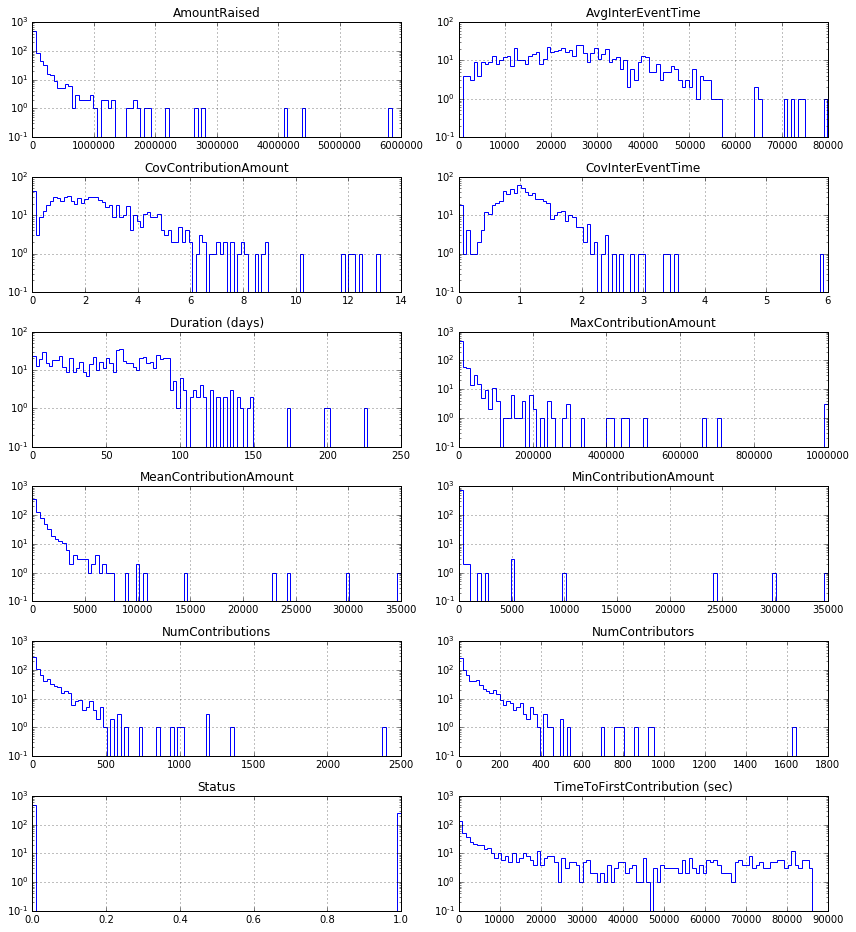

In [27]:
investments_l = investments[lender_features].apply(pd.to_numeric, errors='coerce')
investments_l['Status'] = investments_l['Status'].astype('int32')
investments_l.hist(figsize=(12,15), 
                        layout=(7,2), 
                        histtype='step',
                        bins=100, 
                        log=True)
plt.grid()
plt.tight_layout()
plt.show()

## Model Evaluation

In [28]:
features_crowd = ["NumContributors", "CovInterEventTime", "CovContributionAmount", "TimeToFirstContribution (sec)", "Duration (days)"]

In [29]:
features_platform = ['PassedQuiz', 'EquityPercent', 'PreMoneyValuation', 'NumEntrepreneurs', 'SelfCertification', 'EisComplinat', 'SeisCompliant', 'Slug', 'AmountRequested']

In [30]:
features_all = features_crowd + features_platform

## Class Balancing

In [31]:
# Separate majority and minority classes
df_majority = investments[investments.Status==0]
df_minority = investments[investments.Status==1]
print len(df_majority), len(df_minority)

479 261


In [32]:
# Down-sample majority class
df_majority_downsampled = resample(df_majority,
                                  replace = False,
                                  n_samples = len(df_minority),
                                  random_state = 42)


In [34]:
# Combine minority class with down-sampled majority class
downsampled = pd.concat([df_majority_downsampled, df_minority])
print Counter(downsampled.Status)
downsampled.sample(5)

Counter({False: 261, True: 261})


,AmountRequested,ProjectID,NumContributions,MinContributionAmount,MeanContributionAmount,MaxContributionAmount,AmountRaised,CovContributionAmount,NumContributors,AvgInterEventTime,CovInterEventTime,Status,TimeToFirstContribution (sec),Duration (days),PassedQuiz,EquityPercent,PreMoneyValuation,NumEntrepreneurs,SelfCertification,EisComplinat,SeisCompliant,Slug
711,600000.000,13102,7,20.000,28.571,50.000,200.000,0.474,3,14600.000,2.132,False,840,9,True,20.000,240000000.000,2.000,-1,1,0,949
553,200000.000,10158,246,10.000,1143.780,35000.000,281370.000,3.022,204,17693.143,1.259,True,58080,73,True,5.000,380000000.000,3.000,-1,1,0,2527
593,39000.000,10735,81,10.000,739.877,8000.000,59930.000,2.142,52,27038.250,0.935,True,40020,71,True,5.500,67000000.000,3.000,-1,0,1,865
588,100000.000,10687,110,10.000,1226.636,20000.000,134930.000,2.268,75,12122.202,1.720,True,60,57,True,13.330,65000000.000,2.000,-1,0,1,302
255,100000.000,3594,56,10.000,258.214,2000.000,14460.000,1.505,54,29205.818,1.030,False,81540,39,True,6.250,150000000.000,3.000,-1,0,1,2198


### CEM Data Preparation

In [35]:
# Initialize MinMax Scaler
scaler = MinMaxScaler() 
# CEM variables
cem_features = features_all + ["Status"]

In [36]:
cem = scaler.fit_transform(downsampled[cem_features].fillna(-1))
cem = pd.DataFrame(cem)
cem.columns = cem_features
cem.to_csv("../Data/equity_cem.csv", index=False)
print Counter(cem["Status"])
cem.head()

Counter({0.0: 261, 1.0: 261})


,NumContributors,CovInterEventTime,CovContributionAmount,TimeToFirstContribution (sec),Duration (days),PassedQuiz,EquityPercent,PreMoneyValuation,NumEntrepreneurs,SelfCertification,EisComplinat,SeisCompliant,Slug,AmountRequested,Status
0,0.011,0.255,0.067,0.298,0.352,1.000,0.109,0.007,0.077,0.000,0.000,1.000,0.690,0.015,0.000
1,0.031,0.280,0.221,0.295,0.767,1.000,0.109,0.017,0.308,0.000,0.000,0.000,0.388,0.038,0.000
2,0.007,0.227,0.097,0.184,0.159,1.000,0.158,0.006,0.231,0.000,0.000,1.000,0.877,0.020,0.000
3,0.015,0.287,0.087,0.153,0.339,1.000,0.059,0.014,0.077,0.000,0.000,1.000,0.628,0.015,0.000
4,0.004,0.252,0.067,0.197,0.286,1.000,0.158,0.004,0.231,0.000,0.000,1.000,0.362,0.015,0.000


## Evaluation Results

In [37]:
X = downsampled[features_all].fillna(-1).as_matrix()
X = scaler.fit_transform(X)
y = downsampled['Status'].as_matrix()

In [38]:
evaluation = evaluation_summary(X,y)
evaluation

Completed QDA in 0.0090320110321 seconds
Completed CART in 0.0144801139832 seconds
Completed GNB in 0.00695490837097 seconds
Completed RF in 0.189377069473 seconds
Completed LR in 0.0076789855957 seconds
Completed ADB in 0.384579896927 seconds


,Model,Accuracy,Precision,Recall,F1,AUC
0,QDA,0.567,0.563,0.598,0.580,0.567
1,CART,0.833,0.835,0.831,0.833,0.833
2,GNB,0.521,0.511,0.996,0.675,0.521
3,RF,0.889,0.904,0.870,0.887,0.889
4,LR,0.824,0.814,0.839,0.826,0.824
5,ADB,0.889,0.889,0.889,0.889,0.889


## PIMP

In [39]:
reload(rfpimp)
from rfpimp import *
piRF = rfpimp.permutation_importances(RandomForestClassifier(), downsampled[features_all].fillna(-1), downsampled['Status'], oob_classifier_accuracy)
piRF

,Importance
Feature,
NumContributors,0.236
CovInterEventTime,0.086
CovContributionAmount,0.059
AmountRequested,0.027
EquityPercent,0.017
TimeToFirstContribution (sec),0.010
PreMoneyValuation,0.008
Duration (days),0.006
NumEntrepreneurs,0.002


In [1]:
piRF_summary = defaultdict(list)
for i in tqdm_notebook(range(1,10000)):
    reload(rfpimp)
    from rfpimp import *
    piRF = rfpimp.permutation_importances(RandomForestClassifier(), downsampled[features_all].fillna(-1), downsampled['Status'], oob_classifier_accuracy)
    for feature, pi in zip(piRF.Importance.index, piRF.Importance.values):
            piRF_summary[feature].append(pi)

In [ ]:
df_piRF = pd.DataFrame()
for feature in features_all:
    df_piRF[feature] = piRF_summary[feature]
df_piRF.to_csv("../Data/equity_permutation_importance.csv", index=False)
df_piRF.head(5)

In [ ]:
equity_variables = ["NumContributors", "CovInterEventTime", "CovContributionAmount", "AmountRequested", "Duration (days)", "EquityPercent", "PreMoneyValuation", "TimeToFirstContribution (sec)", "NumEntrepreneurs", "Slug",  "EisComplinat", "SeisCompliant", "PassedQuiz", "SelfCertification"]
equity_labels = ["Appeal *", "Momentum *", "Variation *", "Amount", "Engagement *", "Equity", "Valuation", "Latency *", "Entrepreneurs", "Slug", "EIS Compliant", "SEIS Compliant", "Passed Quiz", "Self Certification"]
red_square = dict(markerfacecolor='w', marker='o')
medianprops = dict(linestyle='-', linewidth=1, color='firebrick')
ax = df_piRF[equity_variables].plot.box(figsize=(6,6), rot='vertical', fontsize=18, 
                     flierprops=red_square, 
                     medianprops=medianprops)
ax.set_xticklabels(equity_labels)
plt.title("Crowd Equity", fontsize=18)
# plt.tight_layout()
plt.show()

# -------------------------------------- End Main ----------------------------------------

# Supplementary

## Crowd Model

In [ ]:
X = investments[features_crowd].fillna(-1).as_matrix()
X = scaler.fit_transform(X)
y = investments['Status']

In [ ]:
evaluation = evaluation_summary(X,y)
evaluation

In [ ]:
frank_summary(X, y, features_crowd)

In [ ]:
D = feature_dependence_matrix(investments[features_crowd].fillna(-1))
plot_dependence_heatmap(D, figsize=(8,8))

## Platform Model

In [ ]:
X = investments[features_platform].fillna(-1).as_matrix()
X = scaler.fit_transform(X)
y = investments['Status']

In [ ]:
evaluation = evaluation_summary(X,y)
evaluation

In [ ]:
frank_summary(X, y, features_platform)

In [ ]:
D = feature_dependence_matrix(investments[features_platform].fillna(-1))
plot_dependence_heatmap(D, figsize=(8,8))

## All Features

In [ ]:
X = investments[features_all].fillna(-1).as_matrix()
X = scaler.fit_transform(X)
y = investments['Status']

In [ ]:
evaluation = evaluation_summary(X,y)
evaluation

## CEM Analysis

In [ ]:
cem = pd.read_csv("../Data/cem_results.csv")
cem = cem.drop(['Unnamed: 0'], axis=1)
cem = cem.astype('str')
cem.head()

In [ ]:
investments["cem"] = cem.apply(lambda x: ''.join(x), axis=1)
investments.head()

In [ ]:
funded_cem = investments[investments.Status == True]
print len(funded_cem)
funded_cem.head()

In [ ]:
unfunded_cem = investments[investments.Status == False]
print len(unfunded_cem)
unfunded_cem.head()

In [ ]:
unfunded_matched = unfunded_cem[unfunded_cem["cem"].isin(funded_cem["cem"])]
print len(unfunded_matched)
unfunded_matched.head()

In [ ]:
fig = plt.figure(figsize=(16,3))
plt.tick_params(size=12)
b = True
s = 12

plt.subplot(1, 5, 1)
sns.kdeplot(funded_cem["EquityPercent"], shade=b, color="g",label="Funded")
sns.kdeplot(unfunded_matched["EquityPercent"], shade=b, color="r", label="Matched")
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.ylabel("Density", size=s)
plt.xlabel("Equity Percent", size=s, labelpad=20)
plt.legend(loc=1)

plt.subplot(1, 5, 2)
sns.kdeplot(funded_cem["PreMoneyValuation"], shade=b, color="g", legend=False)
sns.kdeplot(unfunded_matched["PreMoneyValuation"], shade=b, color="r", legend=False)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.xlabel("PreMoney Valuation", size=s, labelpad=20)

plt.subplot(1, 5, 3)
sns.kdeplot(funded_cem["NumEntrepreneurs"], shade=b, color="g", legend=False)
sns.kdeplot(unfunded_matched["NumEntrepreneurs"], shade=b, color="r", legend=False)
plt.xlabel("NumEntrepreneurs", size=s, labelpad=20)

plt.subplot(1, 5, 4)
sns.kdeplot(funded_cem["SeisCompliant"], shade=b, color="g", legend=False)
sns.kdeplot(funded_cem["SeisCompliant"], shade=b, color="r", legend=False)
plt.xlabel("SeisCompliant", size=s, labelpad=20)

plt.subplot(1, 5, 5)
sns.kdeplot(funded_cem["Slug"], shade=b, color="g", legend=False)
sns.kdeplot(unfunded_matched["Slug"], shade=b, color="r", legend=False)
plt.ticklabel_format(style='sci', axis='both', scilimits=(0,0))
plt.xlabel("Slug", size=s, labelpad=20)

plt.show()

### KS-Test

This tests whether 2 samples are drawn from the same distribution. Note that, like in the case of the one-sample K-S test, the distribution is assumed to be continuous.

This is the two-sided test, one-sided tests are not implemented. The test uses the two-sided asymptotic Kolmogorov-Smirnov distribution.

If the K-S statistic is small or the p-value is high, then we cannot reject the hypothesis that the distributions of the two samples are the same.

If the K-S statistic is high or the p-value is low, then we can <b>reject the hypothesis that the distributions of the two samples are the same.</b>

In [ ]:
print "Appeal:", stats.ks_2samp(funded_cem["NumContributors"], unfunded_cem["NumContributors"])
print "Latency:", stats.ks_2samp(funded_cem["TimeToFirstContribution (sec)"], unfunded_cem["TimeToFirstContribution (sec)"])
print "Momentum:", stats.ks_2samp(funded_cem["CovInterEventTime"], unfunded_cem["CovInterEventTime"])
print "Variation:", stats.ks_2samp(funded_cem["CovContributionAmount"], unfunded_cem["CovContributionAmount"])
print "Duration:", stats.ks_2samp(funded_cem["Duration (days)"], unfunded_cem["Duration (days)"])

### Student T-Test

We can use this test, if we observe two independent samples from the same or different population, e.g. exam scores of boys and girls or of two ethnic groups. The test measures whether the average (expected) value differs significantly across samples. If we observe a large p-value, for example larger than 0.05 or 0.1, then we cannot reject the null hypothesis of identical average scores. If the p-value is smaller than the threshold, e.g. 1%, 5% or 10%, then we reject the null hypothesis of equal averages.

In [ ]:
print "Appeal:", stats.ttest_ind(funded_cem["NumContributors"], unfunded_cem["NumContributors"], equal_var=False)
print "Latency:", stats.ttest_ind(funded_cem["TimeToFirstContribution (sec)"], unfunded_cem["TimeToFirstContribution (sec)"], equal_var=False)
print "Momentum:", stats.ttest_ind(funded_cem["CovInterEventTime"].dropna(), unfunded_cem["CovInterEventTime"].dropna(), equal_var=False)
print "Variation:", stats.ttest_ind(funded_cem["CovContributionAmount"], unfunded_cem["CovContributionAmount"], equal_var=False)
print "Duration:", stats.ttest_ind(funded_cem["Duration (days)"], unfunded_cem["Duration (days)"], equal_var=False)

## Feature Correlations

In [6]:
# corr = investments[features_all+["Status"]].fillna(-1).corr(method='pearson')
# mask = np.zeros_like(corr, dtype=np.bool)
# mask[np.triu_indices_from(mask)] = True
# plt.figure(figsize=(10,10))
# sns.heatmap(corr, 
#         xticklabels=corr.columns,
#         yticklabels=corr.columns,
#         cmap=sns.color_palette("coolwarm_r"),
#         mask = mask,
#         vmin = -1,
#         vmax= 1,
#         linewidths=.5,
#         annot=True)
# plt.title("Variable Correlation Heatmap")
# plt.show()

In [44]:
print stats.pearsonr(investments.Status, investments['NumContributors'])
momentum_ = investments[["Status", "CovInterEventTime"]].dropna()
print stats.pearsonr(momentum_.Status, momentum_.CovInterEventTime)
print stats.pearsonr(investments.Status, investments['CovContributionAmount'])
print stats.pearsonr(investments.Status, investments['TimeToFirstContribution (sec)'])
print stats.pearsonr(investments.Status, investments['Duration (days)'])

(0.5339506216054514, 9.007135649850646e-56)
(0.5176430541361807, 1.027319551407416e-49)
(0.43611829168320154, 1.0405428433498857e-35)
(-0.1837383454263245, 4.836695558059927e-07)
(0.10376422211364413, 0.004719940094812135)
